# Notebook for location using Hypoinverse
References: 
- https://github.com/kaiwenwang233/scoped_ML_tutorial?tab=readme-ov-file
- https://www.usgs.gov/software/hypoinverse-earthquake-location
- https://chatgpt.com/c/67491af9-aaf8-800c-82e9-1033e094d8d0
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JB014966

In [1]:
from datetime import datetime
import pandas as pd
import os 
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import obspy
import pygmt
from obspy.geodetics import degrees2kilometers


## Run HypoInverse

In [2]:
!hyp1.40 < ../hypoInv/hyp_elevation_or_shore.command

 HYPOINVERSE 2000 STARTING
6/2014 VERSION 1.40 (geoid depth possible)                            
 COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?     15 STATIONS READ IN.
 COMMAND?  COMMAND?   Read in crustal model(s):
 COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?   FIND INPUT PHASE FILE TYPE & SET PHS(COP) & ARC(CAR) FORMATS
  INPUT IS A HYPOINVERSE ARCHIVE-2000 FILE, NO SHADOWS
  SETTING FORMATS COP 3, CAR 1
 COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  *** STOP ITERATING EVENT 2011 11  9 17 25 BECAUSE DISTANCE TO SECOND CLOSEST
 *** STATION J33A -7D-BH  IS  292. & EXCEEDS  250. K

## Plot the relocated events by HypoInverse

### Load the output file from HypoInverse

In [2]:
region = 'or_shore'
events_hpy = pd.read_csv(f'../hypoInv/catOut_{region}.sum', names=[ "lines" ])

events_hpy['YRMODY']=events_hpy['lines'].apply(lambda x: x[0:8])
events_hpy['HR']=events_hpy['lines'].apply(lambda x: x[8:10])
events_hpy['MIN']=events_hpy['lines'].apply(lambda x: x[10:12])
events_hpy['SEC']=events_hpy['lines'].apply(lambda x: x[12:16])
events_hpy['LAT']=events_hpy['lines'].apply(lambda x: float(x[16:18])+float(x[19:23])/6000)
events_hpy['LON']=events_hpy['lines'].apply(lambda x: float(x[23:26])+float(x[27:31])/6000)
events_hpy['DEPTH']=events_hpy['lines'].apply(lambda x: float(x[32:36])/100)
events_hpy['RMS']=events_hpy['lines'].apply(lambda x: float(x[48:52])/100)
# events_hpy = events_hpy[events_hpy['RMS']<0.1]
print(len(events_hpy))

21


In [3]:
events_hpy.to_csv(f'../data/datasets_{region}/events_hypoinv_{region}.csv', sep="\t", index=False,
                    columns=["YRMODY", "HR", "MIN", "SEC", "LAT", "LON", "DEPTH", "RMS"])

In [5]:
# Define config 
# GMMAResultDir='./GMMA'
# Path(GMMAResultDir).mkdir(parents=True, exist_ok=True)

# catalog_csv = GMMAResultDir+"/catalog_gamma.csv"
# picks_csv = GMMAResultDir+"/picks_gamma.csv"
# Load stations 

stations = pd.read_csv(f"./stations_{region}.csv", sep="\t")

region_name = "Offshore Washington, Oregon and Northern California"
center = (-125.5, 46.0)
horizontal_degree = 9
vertical_degree = 12
starttime = obspy.UTCDateTime("2011-01-01T00")
endtime =   obspy.UTCDateTime("2015-12-31T23")
network_list = list(pd.read_csv("../data/networks.csv")["networks"])
channel_list = "HH*,BH*" # change if needed

config = {}
config["region"] = region_name
config["center"] = center
config["xlim_degree"] = [center[0] - horizontal_degree / 2, center[0] + horizontal_degree / 2]
config["ylim_degree"] = [center[1] - vertical_degree / 2, center[1] + vertical_degree / 2]
config["starttime"] = starttime.datetime.isoformat()
config["endtime"] = endtime.datetime.isoformat()
config["networks"] = network_list
config["channels"] = channel_list
config["degree2km"] = 111
config["degree2km_x"] = 82
config['vel']= {"p":6.2, "s":3.3}


config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = True
config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km_x"]
config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
config["z(km)"] = (0, 20)

# DBSCAN
config["bfgs_bounds"] = ((config["x(km)"][0]-1, config["x(km)"][1]+1), #x
                        (config["y(km)"][0]-1, config["y(km)"][1]+1), #y
                        (0, config["z(km)"][1]+1), #x
                        (None, None)) #t
config["dbscan_eps"] = 6
config["dbscan_min_samples"] = min(len(stations), 3)
config["min_picks_per_eq"] = min(len(stations)//2+1, 10)

config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

config["max_sigma11"] = 2.0
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

for k, v in config.items():
    print(f"{k}: {v}")

region: Offshore Washington, Oregon and Northern California
center: (-125.5, 46.0)
xlim_degree: [-130.0, -121.0]
ylim_degree: [40.0, 52.0]
starttime: 2011-01-01T00:00:00
endtime: 2015-12-31T23:00:00
networks: ['C8', '7D', '7A', 'CN', 'NV', 'UW', 'UO', 'NC', 'BK', 'TA', 'OO', 'PB', 'X6', 'Z5', 'X9']
channels: HH*,BH*
degree2km: 111
degree2km_x: 82
vel: {'p': 6.2, 's': 3.3}
dims: ['x(km)', 'y(km)', 'z(km)']
use_dbscan: True
use_amplitude: True
x(km): [-369.  369.]
y(km): [-666.  666.]
z(km): (0, 20)
bfgs_bounds: ((-370.0, 370.0), (-667.0, 667.0), (0, 21), (None, None))
dbscan_eps: 6
dbscan_min_samples: 3
min_picks_per_eq: 8
method: BGMM
oversample_factor: 4
max_sigma11: 2.0
max_sigma22: 1.0
max_sigma12: 1.0


### Plot the events 

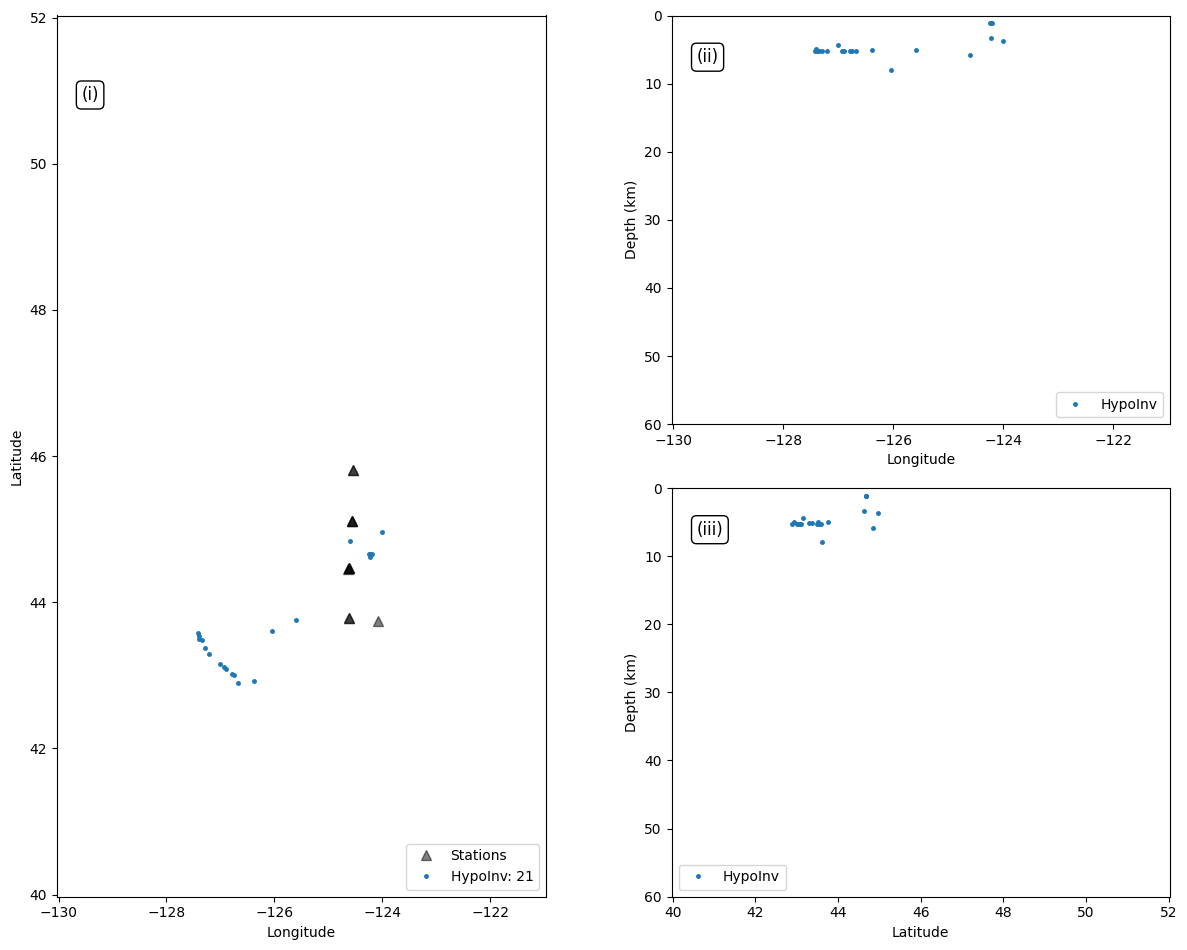

In [6]:
# Load stations 
stations = pd.read_csv(f"./stations_{region}.csv", sep="\t")

# Plot the events 
marker_size=5
hyp_label="HypoInv"
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([2,2]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=1.5*marker_size, alpha=0.5, label="Stations")
plt.plot(events_hpy["LON"]*(-1), events_hpy["LAT"], '.',markersize=marker_size, alpha=1.0, rasterized=True, label=f"{hyp_label}: {len(events_hpy)}")

plt.gca().set_aspect(111/82)
plt.xlim(np.array(config["xlim_degree"])+np.array([-0.03,0.03]))
plt.ylim(np.array(config["ylim_degree"])+np.array([-0.03,0.03]))
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10)
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(events_hpy["LON"]*(-1), events_hpy["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hyp_label}")

plt.xlim(np.array(config["xlim_degree"])+np.array([-0.03,0.03]))
plt.ylim(bottom=0, top=60)
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, 31, '.', markersize=10)
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)


fig.add_subplot(grd[1, 1])
plt.plot(events_hpy["LAT"], events_hpy["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hyp_label}")

plt.xlim(np.array(config["ylim_degree"])+np.array([-0.03,0.03]))
plt.ylim(bottom=0, top=60)
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0]-10, 31, '.', markersize=10)
plt.legend(loc="lower left")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(f"relocated_events_profile_hypoinv_{region}.pdf")

plt.show()

### Make a plot with topography

events_hpy columns: Index(['lines', 'YRMODY', 'HR', 'MIN', 'SEC', 'LAT', 'LON', 'DEPTH', 'RMS'], dtype='object')
stations columns: Index(['Unnamed: 0', 'station', 'longitude', 'latitude', 'elevation(m)',
       'component', 'response', 'unit', 'id'],
      dtype='object')
Length of events_hpy['LON']: 21
Length of events_hpy['LAT']: 21
Length of stations['longitude']: 15
Length of stations['latitude']: 15


/tmp/ipykernel_2095690/1540304305.py:40: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


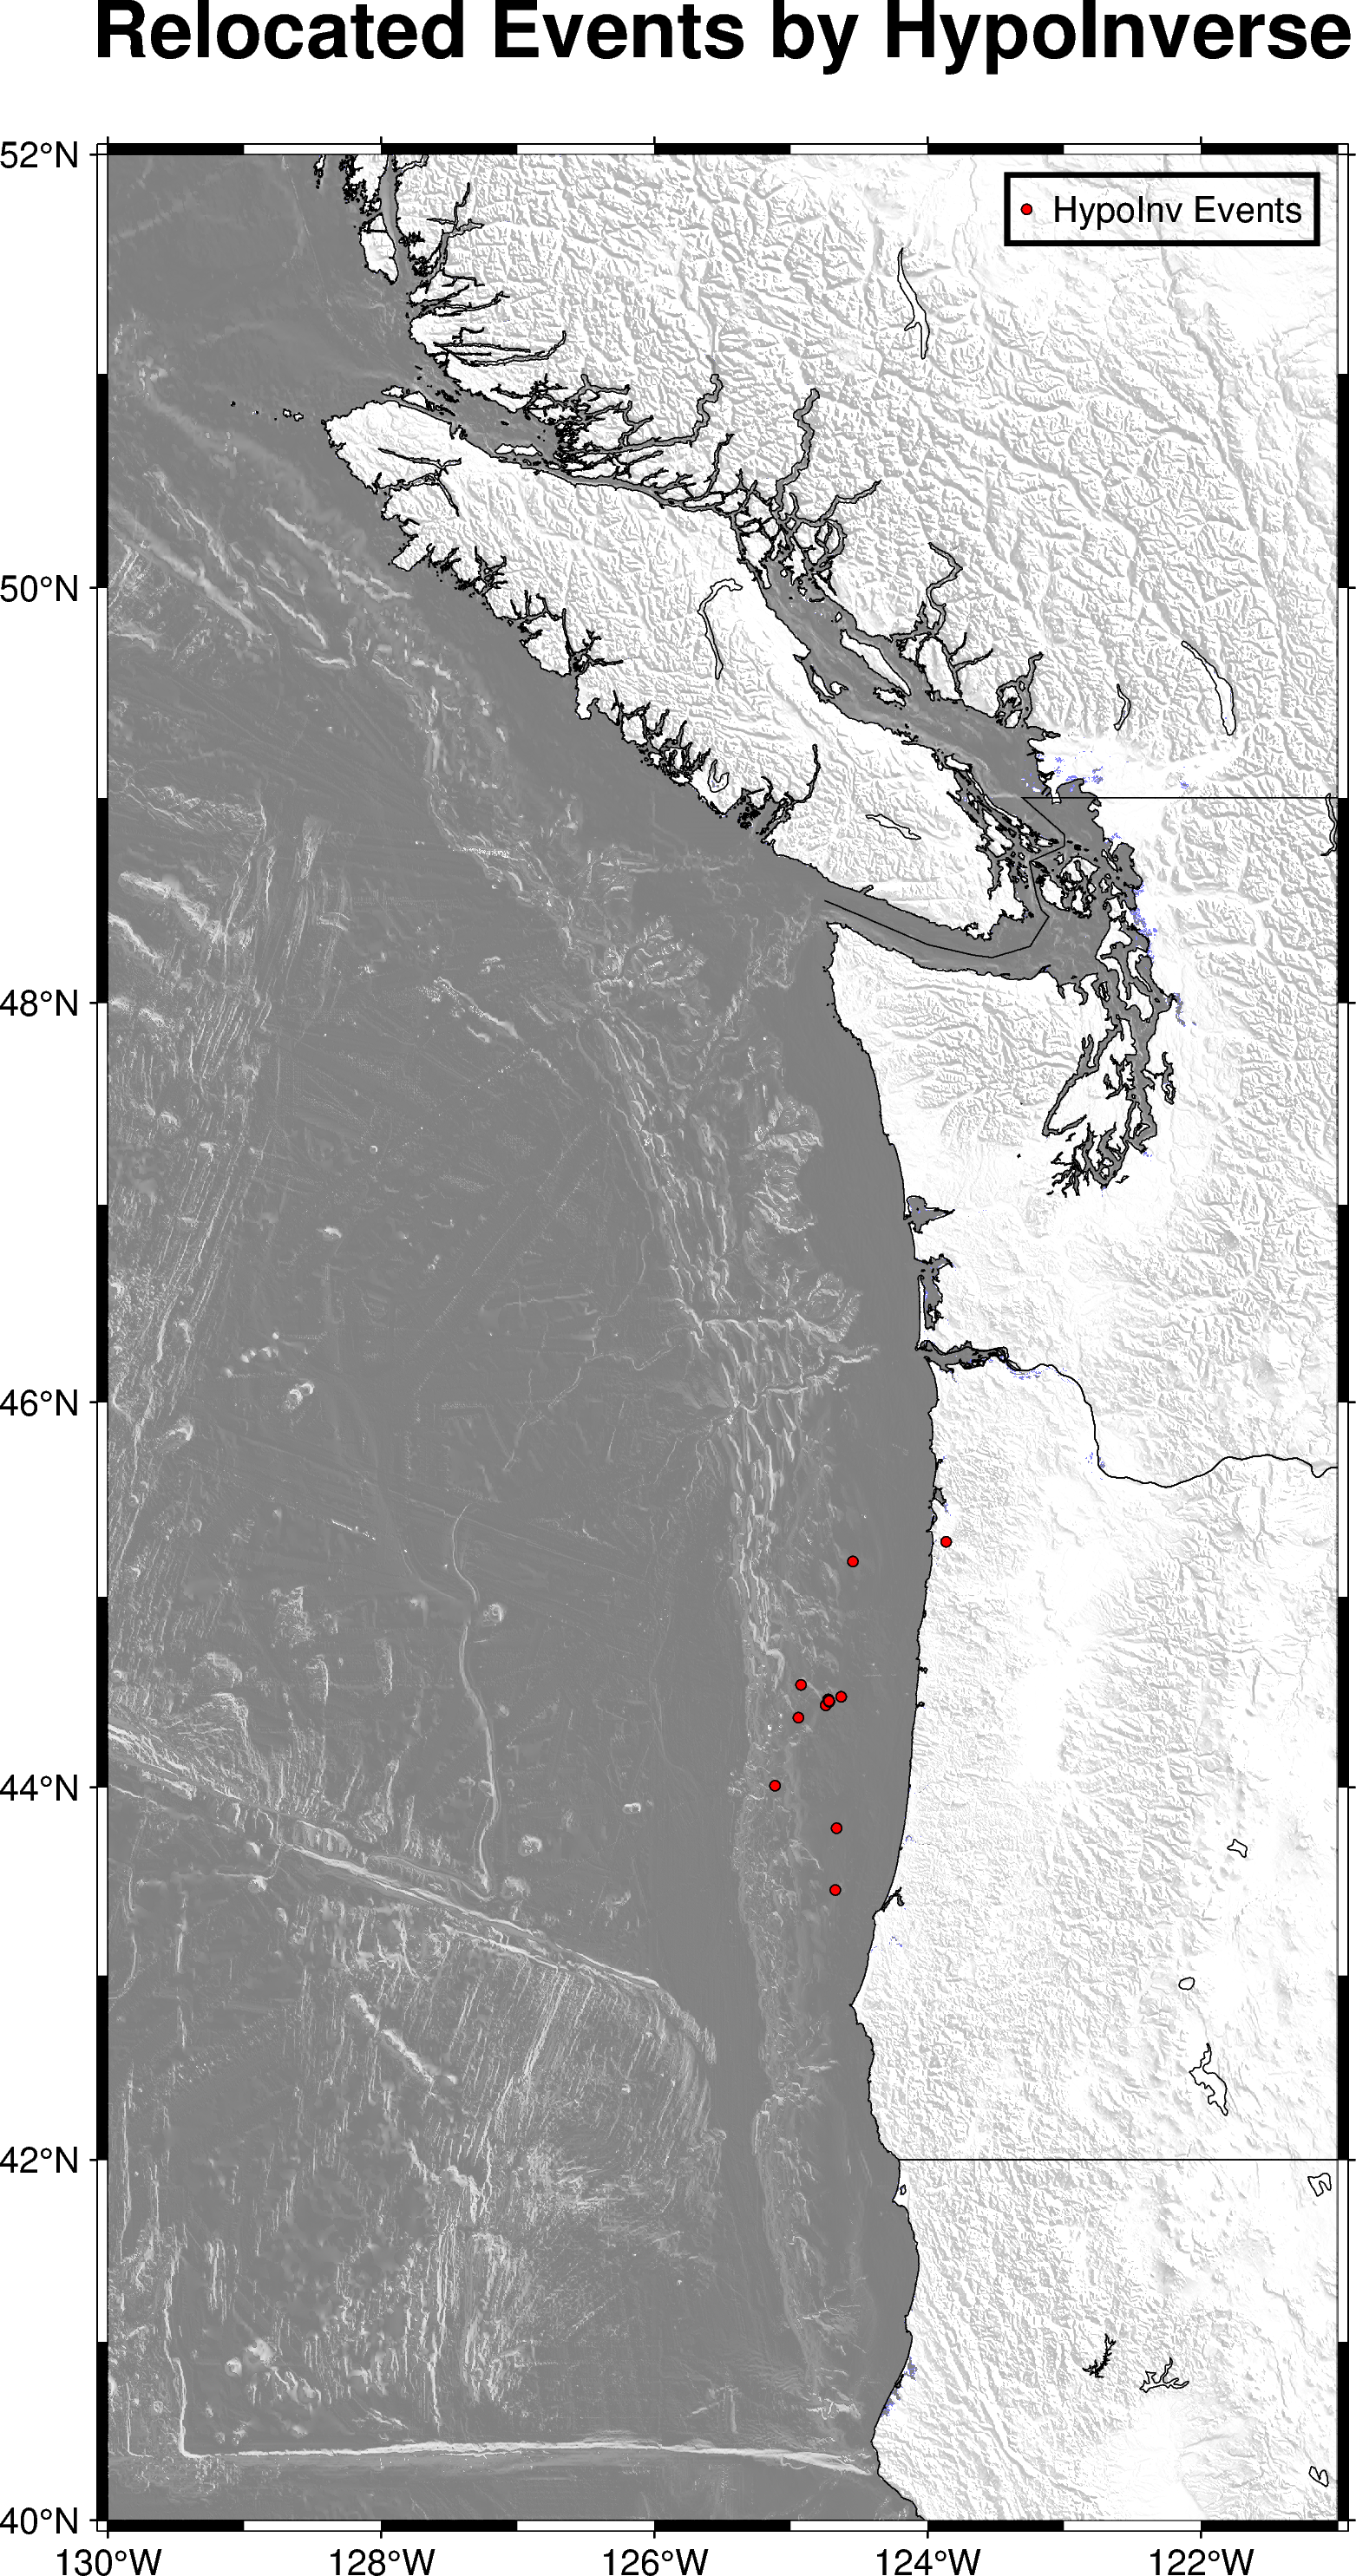

In [8]:
# Parameters
region_id = region 

# Define target region
min_lat = 40
max_lat = 52
min_lon = -130
max_lon = -121

# Plotting parameters
transparency = 60

# Initialize the figure
fig = pygmt.Figure()

# Load grid data
grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[min_lon, max_lon, min_lat, max_lat])
shade = pygmt.grdgradient(grid=grid, azimuth="0/90", normalize="t1")

# Define target region
region = [min_lon, max_lon, min_lat, max_lat]
title = "Relocated Events by HypoInverse"
fig.basemap(region=region, projection="M12c", frame=["af", f"WSne+t{title}"])

fig.grdimage(grid=grid, cmap="blue", shading=shade, transparency=50)
fig.coast(region=region, projection="M12c", shorelines=True, borders=[1, 2], resolution="f")


# Debugging: Print the columns of the DataFrames
print("events_hpy columns:", events_hpy.columns)
print("stations columns:", stations.columns)

# Debugging: Print the lengths of the columns
print("Length of events_hpy['LON']:", len(events_hpy['LON']))
print("Length of events_hpy['LAT']:", len(events_hpy['LAT']))
print("Length of stations['longitude']:", len(stations['longitude']))
print("Length of stations['latitude']:", len(stations['latitude']))

# Plotting data points with dynamic transparency and sizes
fig.plot(
    x=events_hpy['LON']*(-1),
    y=events_hpy["LAT"],
    style="c0.1c",  # Circle with size 0.1 cm
    color='red',
    pen="black",
    label='HypoInv Events'
)

# Plot stations
# fig.plot(
#     x=stations['longitude'],
#     y=stations['latitude'],
#     style="t0.2c",  # Triangle with size 0.2 cm
#     pen="black",
#     fill = "gray",
#     label="Stations"
# )

fig.legend(position="jTR+o0.2c", box=True)

# Save and display the figure
fig.savefig(f"relocated_events_hypoinv_{region_id}.pdf")
fig.show()

### Plot a cross section

Text(0.5, 1.0, 'Cross Section at 44°')

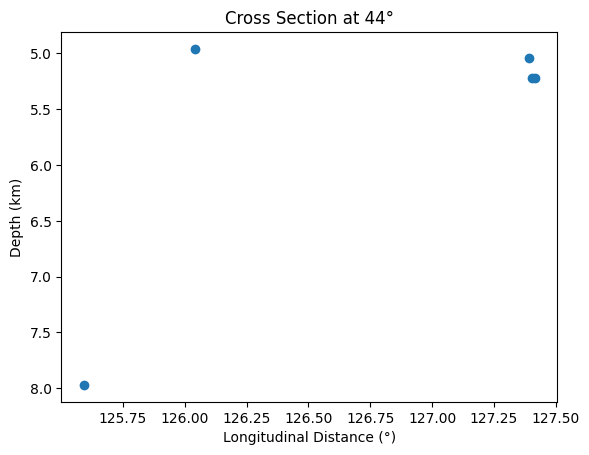

In [5]:
exact_lat = 44 # the exact latitude that you want the cross section to be at
deg = 0.5
events = events_hpy 
events_lat = events.loc[(events['LAT']>exact_lat-deg)&(events['LAT']<exact_lat+deg)]
lon = list(events_lat['LON'].sort_values(ascending=True))
depth = events_lat['DEPTH']
dist = []
for i in lon:
    dist1 = degrees2kilometers(i-lon[0])
    dist.append(abs(dist1))

plt.figure()
plt.scatter(lon,depth)
plt.gca().invert_yaxis()
plt.xlabel('Longitudinal Distance (\xb0)')
plt.ylabel('Depth (km)')
plt.title(f'Cross Section at {exact_lat}\xb0')